# 01 - Data Preprocessing

This notebook demonstrates the preprocessing pipeline for single-cell RNA-seq data.

## Overview

The preprocessing steps include:
1. Data loading
2. Quality control metrics calculation
3. Cell and gene filtering
4. Normalization
5. Highly variable gene identification
6. Dimensionality reduction (PCA)

## Setup

In [58]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Set random seed for reproducibility
np.random.seed(42)

print(f"Scanpy version: {sc.__version__}")

Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_24864\2348608299.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration

In [59]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully")
print(f"Min genes per cell: {config['preprocessing']['min_genes_per_cell']}")
print(f"Min genes per cell: {config['preprocessing']['max_genes_per_cell']}")
print(f"Max mitochondrial %: {config['preprocessing']['max_mito_percent']}")

Configuration loaded successfully
Min genes per cell: 200
Min genes per cell: 30000
Max mitochondrial %: 15


## Load Data

Load your single-cell RNA-seq data. This example shows loading from different formats.

In [60]:
# Example 1: Load from 10X directory
adata = sc.read_10x_mtx(
    '../data/raw/filtered_feature_bc_matrix',
    var_names='gene_symbols',
    cache=True
)

# Example 2: Load from h5ad file
# adata = sc.read_h5ad('../data/raw/sample.h5ad')

# Example 3: Create toy dataset for demonstration
# adata = sc.datasets.pbmc3k()

print(f"Data shape: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

... reading from cache file cache\..-data-raw-filtered_feature_bc_matrix-matrix.h5ad
Data shape: 8272 cells x 32285 genes


AnnData object with n_obs × n_vars = 8272 × 32285
    var: 'gene_ids', 'feature_types'

## Quality Control

Calculate QC metrics and visualize data quality.

In [61]:
# Identify mitochondrial genes
# Check different naming conventions (MT- for human, mt- or Mt- for mouse)
for prefix in ['MT-', 'mt-', 'Mt-']:
    mt_genes = adata.var_names.str.startswith(prefix)
    if mt_genes.sum() > 0:
        adata.var['mt'] = mt_genes
        print(f"Found {mt_genes.sum()} mitochondrial genes with prefix '{prefix}'")
        break
else:
    # If no standard prefix found, try case-insensitive match
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    if adata.var['mt'].sum() > 0:
        print(f"Found {adata.var['mt'].sum()} mitochondrial genes (case-insensitive)")
    else:
        print("Warning: No mitochondrial genes found. Check gene naming convention.")
        adata.var['mt'] = False

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

print("QC metrics calculated")

Found 13 mitochondrial genes with prefix 'mt-'
QC metrics calculated


In [62]:
# Check what mitochondrial genes were identified
print("\nMitochondrially-encoded genes found:")
print(adata.var_names[adata.var['mt']].tolist())

# Note: For QC, we typically use mitochondrially-ENCODED genes (~13 protein-coding genes)
# not nuclear-encoded mitochondrial proteins (~1100+ genes).
# High % of mitochondrially-encoded transcripts indicates cellular stress/dying cells.



Mitochondrially-encoded genes found:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


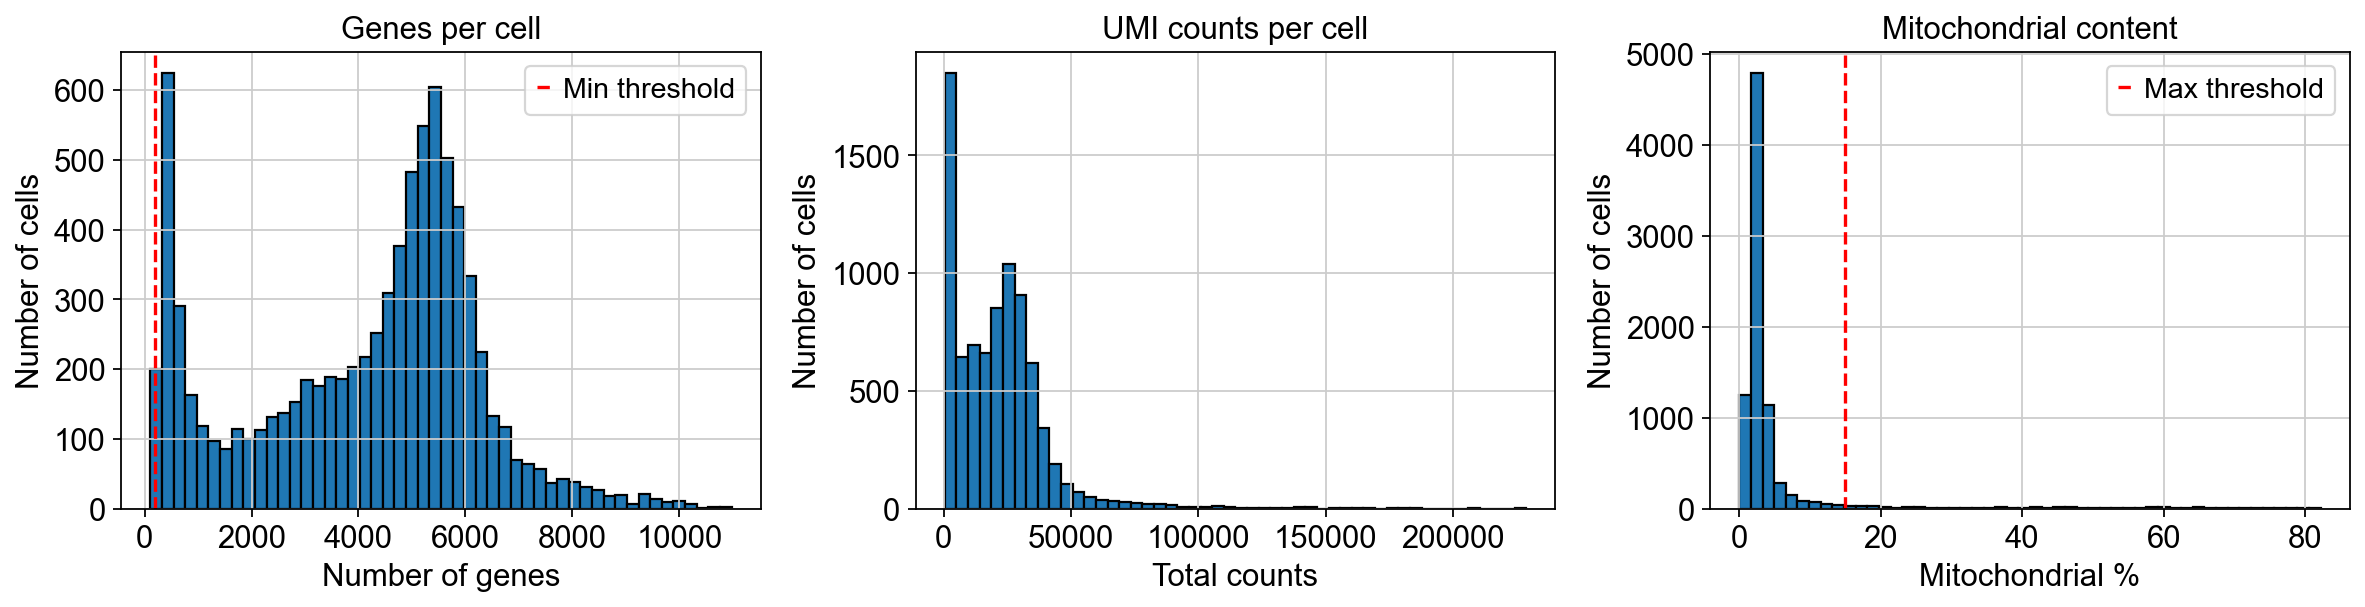

In [63]:
# Visualize QC metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Number of genes per cell
axes[0].hist(adata.obs['n_genes_by_counts'], bins=50, edgecolor='black')
axes[0].set_xlabel('Number of genes')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Genes per cell')
axes[0].axvline(config['preprocessing']['min_genes_per_cell'], color='r', linestyle='--', label='Min threshold')
axes[0].legend()

# Plot 2: Total counts per cell
axes[1].hist(adata.obs['total_counts'], bins=50, edgecolor='black')
axes[1].set_xlabel('Total counts')
axes[1].set_ylabel('Number of cells')
axes[1].set_title('UMI counts per cell')

# Plot 3: Mitochondrial percentage
axes[2].hist(adata.obs['pct_counts_mt'], bins=50, edgecolor='black')
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Number of cells')
axes[2].set_title('Mitochondrial content')
axes[2].axvline(config['preprocessing']['max_mito_percent'], color='r', linestyle='--', label='Max threshold')
axes[2].legend()

plt.tight_layout()
plt.show()

## Doublet Detection

Identify potential doublets (two cells captured together) using Scrublet. This is more robust than using a hard gene count threshold.

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 4.2%
Elapsed time: 49.9 seconds
Detected 2 doublets (0.02%)


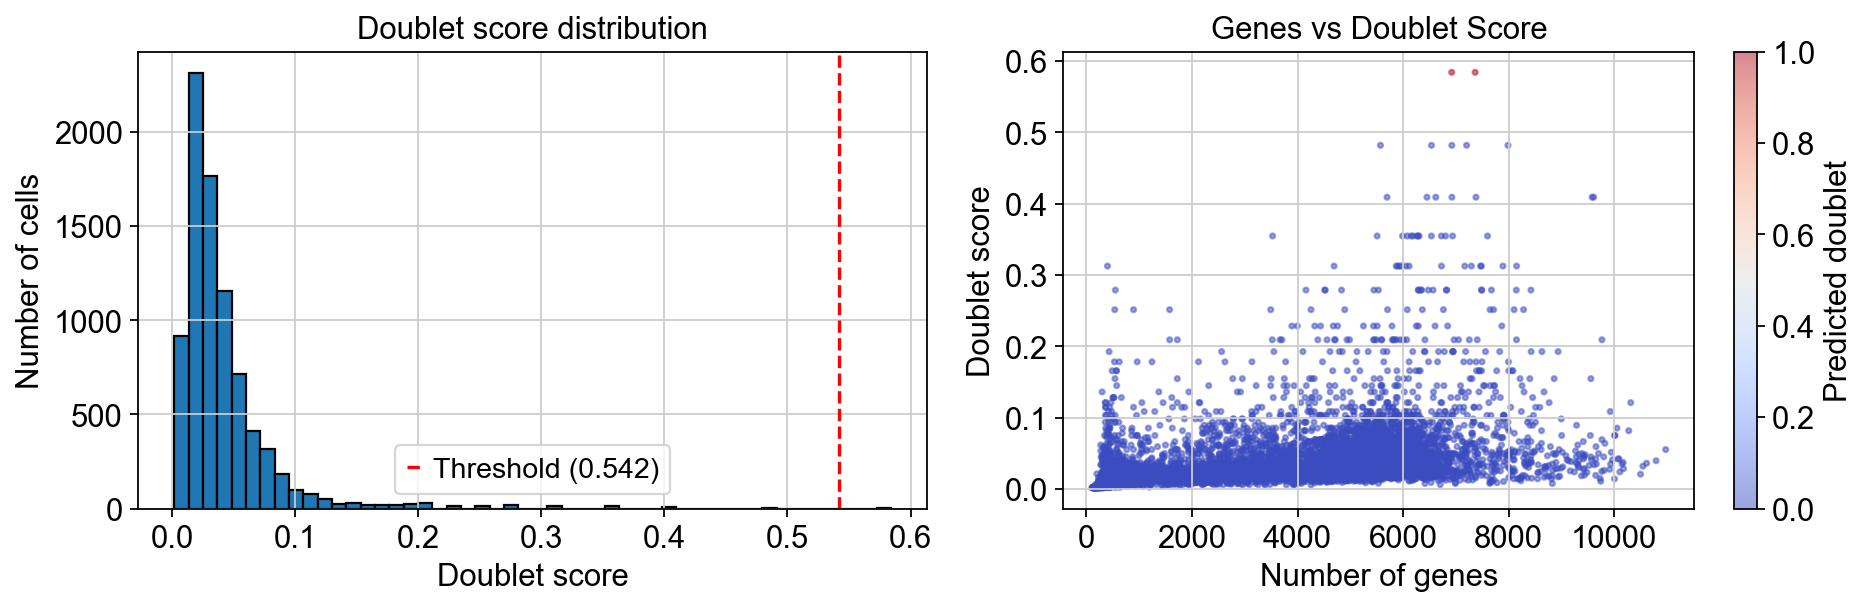

In [64]:
import scrublet as scr

# Run Scrublet
scrub = scr.Scrublet(adata.X, expected_doublet_rate=config['quality_control']['doublet_rate'])
doublet_scores, predicted_doublets = scrub.scrub_doublets(
    min_counts=2,
    min_cells=3,
    min_gene_variability_pctl=85,
    n_prin_comps=30
)

# Add results to adata
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

print(f"Detected {predicted_doublets.sum()} doublets ({100 * predicted_doublets.sum() / len(predicted_doublets):.2f}%)")

# Visualize doublet scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of doublet scores
axes[0].hist(doublet_scores, bins=50, edgecolor='black')
axes[0].set_xlabel('Doublet score')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Doublet score distribution')
axes[0].axvline(scrub.threshold_, color='r', linestyle='--', label=f'Threshold ({scrub.threshold_:.3f})')
axes[0].legend()

# Doublet scores vs gene count
scatter = axes[1].scatter(adata.obs['n_genes_by_counts'], doublet_scores, 
                          c=predicted_doublets, cmap='coolwarm', s=5, alpha=0.5)
axes[1].set_xlabel('Number of genes')
axes[1].set_ylabel('Doublet score')
axes[1].set_title('Genes vs Doublet Score')
plt.colorbar(scatter, ax=axes[1], label='Predicted doublet')

plt.tight_layout()
plt.show()

## Filtering

Filter cells and genes based on QC thresholds.

In [65]:
print(f"Before filtering: {adata.shape[0]} cells x {adata.shape[1]} genes")

# Filter doublets if enabled in config and doublet detection was run
if config['quality_control']['filter_doublets']:
    if 'predicted_doublet' in adata.obs.columns:
        adata = adata[~adata.obs['predicted_doublet'], :].copy()
        print(f"After doublet removal: {adata.shape[0]} cells x {adata.shape[1]} genes")
    else:
        print("Warning: Doublet detection not run. Run the doublet detection cell first.")

# Filter cells by gene count
sc.pp.filter_cells(adata, min_genes=config['preprocessing']['min_genes_per_cell'])

# Filter based on mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < config['preprocessing']['max_mito_percent'], :].copy()

# Filter genes
sc.pp.filter_genes(adata, min_cells=config['preprocessing']['min_cells_per_gene'])

print(f"After filtering: {adata.shape[0]} cells x {adata.shape[1]} genes")

Before filtering: 8272 cells x 32285 genes
After doublet removal: 8270 cells x 32285 genes
filtered out 76 cells that have less than 200 genes expressed
filtered out 8743 genes that are detected in less than 3 cells
After filtering: 7839 cells x 23542 genes


## Normalization

Normalize counts and log-transform.

In [66]:
# Store raw counts
adata.layers['counts'] = adata.X.copy()

# Normalize to target sum
sc.pp.normalize_total(adata, target_sum=config['preprocessing']['target_sum'])

# Log transform
sc.pp.log1p(adata)

# Store normalized data
adata.layers['log1p_norm'] = adata.X.copy()

print("Normalization complete")

normalizing counts per cell
    finished (0:00:00)
Normalization complete


### Why log1p transformation?

**log1p(x) = log(1 + x)** is used for several reasons:

1. **Handles zeros**: log(0) is undefined, but log(1+0) = 0. scRNA-seq has many zeros (dropout/lowly expressed genes)

2. **Variance stabilization**: Raw counts have variance proportional to mean (heteroscedastic). Log transformation makes variance more uniform across expression levels

3. **Approximates normality**: Log-transformed data is closer to normal distribution, which many statistical tests assume

4. **Interpretability**: Differences in log space ≈ fold-changes. log(2x) - log(x) = log(2) regardless of x

5. **Down-weights noise**: For low counts (1→2), absolute change is small but relative is 2×. Log1p treats this appropriately as uncertain.

**Is it prone to errors?**
- For very small values (0-3), log1p compresses differences more than linear scale
- But this is *desirable* - low count differences are unreliable (technical noise)
- After normalization to 10,000 UMIs/cell, most expressed genes have values >1 where log1p behaves well

**Alternatives**: Variance-stabilizing transformations (VST), negative binomial GLMs. But log1p remains standard for simplicity and interpretability.

In [1]:
# Visualize the effect of log1p transformation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get raw and normalized data for one gene
example_gene = adata.var_names[100]  # Pick an example gene
raw_counts = adata.layers['counts'][:, 100]
norm_counts = np.expm1(adata.X[:, 100].toarray().flatten())  # Reverse log1p to get normalized
log_norm = adata.X[:, 100].toarray().flatten()

# 1. Raw counts distribution (before normalization)
axes[0, 0].hist(raw_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Raw Counts')
axes[0, 0].set_ylabel('Number of Cells')
axes[0, 0].set_title(f'Raw Counts Distribution ({example_gene})')
axes[0, 0].set_yscale('log')

# 2. After normalization (before log)
axes[0, 1].hist(norm_counts, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Normalized Counts')
axes[0, 1].set_ylabel('Number of Cells')
axes[0, 1].set_title('After Normalization (linear scale)')
axes[0, 1].set_yscale('log')

# 3. After log1p transformation
axes[1, 0].hist(log_norm, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('log1p(Normalized Counts)')
axes[1, 0].set_ylabel('Number of Cells')
axes[1, 0].set_title('After log1p (final values)')

# 4. Effect of log1p function
x_vals = np.linspace(0, 10, 100)
y_log1p = np.log1p(x_vals)
y_log = np.log(x_vals + 0.0001)  # Can't take log(0)

axes[1, 1].plot(x_vals, y_log1p, label='log1p(x) = log(1+x)', linewidth=2)
axes[1, 1].plot(x_vals, x_vals, '--', label='linear (x)', alpha=0.5)
axes[1, 1].axhline(y=0, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].axvline(x=0, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].set_xlabel('Input Value (normalized counts)')
axes[1, 1].set_ylabel('Output Value')
axes[1, 1].set_title('log1p Transformation Function')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExample gene: {example_gene}")
print(f"Range of normalized counts: {norm_counts.min():.3f} - {norm_counts.max():.3f}")
print(f"Range after log1p: {log_norm.min():.3f} - {log_norm.max():.3f}")
print(f"\nZeros in raw data: {(raw_counts == 0).sum()} / {len(raw_counts)} cells ({100*(raw_counts == 0).sum()/len(raw_counts):.1f}%)")

NameError: name 'plt' is not defined

## Highly Variable Genes

Identify genes with high variability across cells.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Identified 2000 highly variable genes


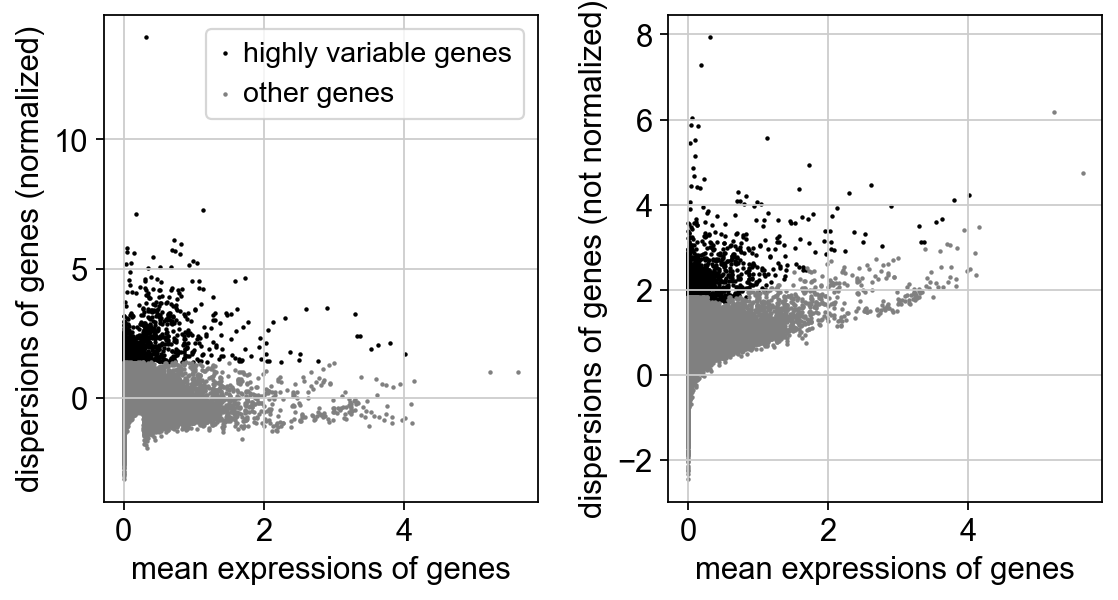

In [67]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=config['normalization']['highly_variable_genes'],
    subset=False,
    flavor='seurat'
)

print(f"Identified {adata.var['highly_variable'].sum()} highly variable genes")

# Visualize
sc.pl.highly_variable_genes(adata)

## Scaling and PCA

Scale data and perform dimensionality reduction.

In [68]:
# Scale data
sc.pp.scale(adata, max_value=config['normalization']['scale_max'])

# Perform PCA
sc.tl.pca(adata, n_comps=config['cell_annotation']['n_pcs'], svd_solver='arpack')

print("PCA complete")

c:\Users\dell\anaconda3\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:04)
PCA complete


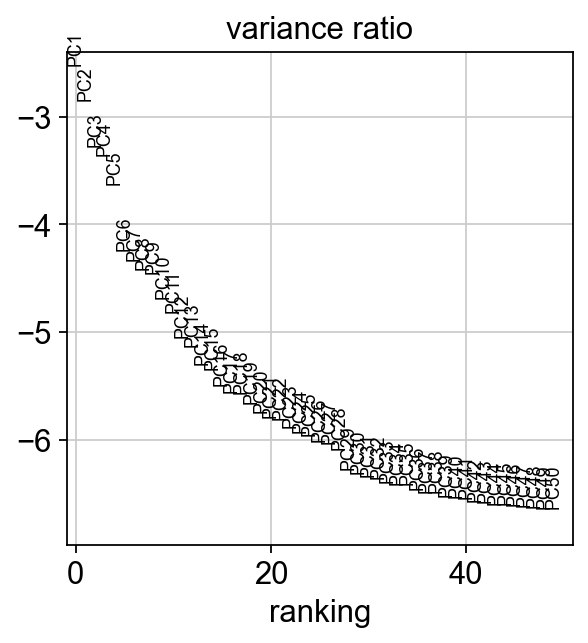

In [69]:
# Visualize PCA variance
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Save Processed Data

In [70]:
# Save processed data
output_file = '../data/processed/preprocessed_data.h5ad'
adata.write(output_file, compression='gzip')

print(f"Saved processed data to {output_file}")
print(f"Final dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")

Saved processed data to ../data/processed/preprocessed_data.h5ad
Final dataset: 7839 cells x 23542 genes


## Next Steps

Proceed to notebook `02_cell_type_annotation.ipynb` for clustering and cell type identification.